# STATS 201 Final Project Notebook

## Research Question
Which socioeconomic and health-system indicators most strongly predict national life expectancy, and how do different feature representations and modeling strategies affect predictive performance?

This final notebook uses outputs and data from notebooks in the main `Codes/` folder only (`export.ipynb`, `data_cleaning.ipynb`, `exploratory_analysis.ipynb`, `train_models.ipynb`).


## 1) Imports and Project Paths

In [1]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
RANDOM_STATE = 42

DATA_DIR = Path('../Assets/cleaner_exports')
IMG_DIR = Path('../Images')
IMG_DIR.mkdir(parents=True, exist_ok=True)

FULL_PATH = DATA_DIR / 'health_panel_ml_numeric.csv'
TRAIN_PATH = DATA_DIR / 'train_temporal_2000_2017.csv'
TEST_PATH = DATA_DIR / 'test_temporal_2018_2021.csv'
CMP_PATH = DATA_DIR / 'model_comparison_temporal.csv'
IMP_PATH = DATA_DIR / 'feature_importance_analysis_temporal.csv'
ROB_PATH = DATA_DIR / 'robustness_checks_temporal.csv'

for p in [FULL_PATH, TRAIN_PATH, TEST_PATH, CMP_PATH, IMP_PATH, ROB_PATH]:
    if not p.exists():
        raise FileNotFoundError(f'Missing required file: {p.resolve()}')

print('Data directory :', DATA_DIR.resolve())
print('Images directory:', IMG_DIR.resolve())


Data directory : /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports
Images directory: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images


## 2) Load Data and Model-Comparison Evidence

In [2]:
full_df = pd.read_csv(FULL_PATH)
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
comparison_df = pd.read_csv(CMP_PATH).sort_values(['Test_R2', 'R2_Gap'], ascending=[False, True]).reset_index(drop=True)
importance_df = pd.read_csv(IMP_PATH)
robustness_df = pd.read_csv(ROB_PATH)

print('Full shape :', full_df.shape)
print('Train shape:', train_df.shape, '| years:', int(train_df['Year'].min()), '-', int(train_df['Year'].max()))
print('Test shape :', test_df.shape, '| years:', int(test_df['Year'].min()), '-', int(test_df['Year'].max()))

best_row = comparison_df.iloc[0]
print('Best combination from model_comparison_temporal.csv:')
print(best_row[['Model', 'Feature_Set', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'R2_Gap']])

display(comparison_df.head(10))


Full shape : (4224, 19)
Train shape: (3456, 19) | years: 2000 - 2017
Test shape : (768, 19) | years: 2018 - 2021
Best combination from model_comparison_temporal.csv:
Model          Random Forest (n_estimators=300, max_depth=15)
Feature_Set                                      log_enhanced
Test_R2                                              0.988479
Test_RMSE                                            0.754141
Test_MAE                                             0.521731
R2_Gap                                               0.011215
Name: 0, dtype: object


,Model,Feature_Set,Train_R2,Test_R2,R2_Gap,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,N_Features
0,"Random Forest (n_estimators=300, max_depth=15)",log_enhanced,0.999694,0.988479,0.011215,0.150385,0.754141,0.103960,0.521731,12
1,"Random Forest (n_estimators=300, max_depth=15)",baseline,0.999694,0.988453,0.011241,0.150296,0.754979,0.103886,0.522663,12
2,"Random Forest (n_estimators=300, max_depth=15)",polynomial,0.999626,0.986593,0.013033,0.166244,0.813526,0.116054,0.553147,18
3,"Gradient Boosting (n_estimators=200, max_depth=3)",polynomial,0.996620,0.984899,0.011721,0.499744,0.863406,0.383246,0.633687,18
4,"Gradient Boosting (n_estimators=200, max_depth=3)",log_enhanced,0.996581,0.984841,0.011740,0.502604,0.865054,0.385418,0.631908,12
5,"Gradient Boosting (n_estimators=200, max_depth=3)",baseline,0.996581,0.984837,0.011743,0.502604,0.865157,0.385418,0.631967,12
6,Lasso (alpha=0.001),polynomial,0.987252,0.980063,0.007189,0.970462,0.992054,0.715437,0.752852,18
7,Linear Regression,polynomial,0.987254,0.980017,0.007237,0.970380,0.993201,0.716487,0.754527,18
8,Ridge (alpha=1.0),polynomial,0.987254,0.980014,0.007240,0.970392,0.993269,0.716059,0.754558,18
9,Decision Tree (max_depth=10),baseline,0.994534,0.977023,0.017512,0.635444,1.065014,0.466003,0.777341,12


## 3) Best Model and Best Feature Engineering Choice

In [3]:
TARGET_COL = 'life_expectancy'

baseline_features = [
    'adult_mortality_15_60',
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
    'infant_deaths',
    'u5_mortality_rate',
]

log_enhanced_features = [
    'adult_mortality_15_60',
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'log_gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
    'log_infant_deaths',
    'u5_mortality_rate',
]

poly_base_cols = ['adult_mortality_15_60', 'u5_mortality_rate', 'log_gdp_per_capita_2015usd']

feature_set_map = {
    'baseline': baseline_features,
    'log_enhanced': log_enhanced_features,
}

best_model_name = str(best_row['Model'])
best_feature_set = str(best_row['Feature_Set'])

print('Selected best model       :', best_model_name)
print('Selected feature strategy :', best_feature_set)

if best_feature_set not in ['baseline', 'log_enhanced', 'polynomial']:
    raise ValueError(f'Unexpected feature set in comparison table: {best_feature_set}')


Selected best model       : Random Forest (n_estimators=300, max_depth=15)
Selected feature strategy : log_enhanced


In [4]:
def make_model_by_name(name: str):
    if name == 'DummyRegressor':
        return DummyRegressor(strategy='mean')
    if name == 'Linear Regression':
        return LinearRegression()
    if name == 'Decision Tree (max_depth=10)':
        return DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=RANDOM_STATE)
    if name == 'Random Forest (n_estimators=300, max_depth=15)':
        return RandomForestRegressor(n_estimators=300, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1)
    if name == 'Gradient Boosting (n_estimators=200, max_depth=3)':
        return GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=RANDOM_STATE)
    if name == 'Ridge (alpha=1.0)':
        return Ridge(alpha=1.0, random_state=RANDOM_STATE)
    if name == 'Lasso (alpha=0.001)':
        return Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=20000)
    raise ValueError(f'Unknown model: {name}')


def build_matrices(train_df, test_df, feature_set: str):
    if feature_set in ['baseline', 'log_enhanced']:
        use_cols = feature_set_map[feature_set]

        X_train_raw = train_df[use_cols].copy()
        X_test_raw = test_df[use_cols].copy()

        imp = SimpleImputer(strategy='median')
        scl = StandardScaler()
        Xtr = scl.fit_transform(imp.fit_transform(X_train_raw))
        Xte = scl.transform(imp.transform(X_test_raw))
        return Xtr, Xte, use_cols

    # polynomial uses log_enhanced base + polynomial terms on key drivers
    use_cols = log_enhanced_features
    X_train_raw = train_df[use_cols].copy()
    X_test_raw = test_df[use_cols].copy()

    imp = SimpleImputer(strategy='median')
    scl = StandardScaler()
    X_train_scaled = scl.fit_transform(imp.fit_transform(X_train_raw))
    X_test_scaled = scl.transform(imp.transform(X_test_raw))

    base_idx = [use_cols.index(c) for c in poly_base_cols]
    poly = PolynomialFeatures(degree=2, include_bias=False)
    Xtr_poly = poly.fit_transform(X_train_scaled[:, base_idx])
    Xte_poly = poly.transform(X_test_scaled[:, base_idx])

    poly_names = poly.get_feature_names_out(poly_base_cols).tolist()
    pass_cols = [c for c in use_cols if c not in poly_base_cols]
    pass_idx = [use_cols.index(c) for c in pass_cols]

    Xtr = np.hstack([X_train_scaled[:, pass_idx], Xtr_poly])
    Xte = np.hstack([X_test_scaled[:, pass_idx], Xte_poly])
    feat_names = pass_cols + poly_names
    return Xtr, Xte, feat_names


X_train, X_test, best_feature_names = build_matrices(train_df, test_df, best_feature_set)
y_train = train_df[TARGET_COL].values
y_test = test_df[TARGET_COL].values

final_model = make_model_by_name(best_model_name)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

final_metrics = {
    'Test_R2': float(r2_score(y_test, y_pred)),
    'Test_RMSE': float(np.sqrt(mean_squared_error(y_test, y_pred))),
    'Test_MAE': float(mean_absolute_error(y_test, y_pred)),
}

print('Re-fit best model metrics on temporal test split:')
print(final_metrics)


Re-fit best model metrics on temporal test split:
{'Test_R2': 0.9884790153602158, 'Test_RMSE': 0.7541407630445216, 'Test_MAE': 0.5217307886901014}


## 4) Indicators That Most Strongly Predict Life Expectancy

,Feature,Importance,Percent_Of_Total,Indicator_Group
0,adult_mortality_15_60,0.880895,88.089479,Health outcomes / mortality
1,u5_mortality_rate,0.104453,10.445301,Health outcomes / mortality
2,log_gdp_per_capita_2015usd,0.003112,0.311194,Socioeconomic
3,thinness_children_adolescents_pct,0.003000,0.300030,Population risk profile
4,alcohol_per_capita_15plus,0.002677,0.267716,Behavioral / lifestyle
5,log_infant_deaths,0.001485,0.148477,Health outcomes / mortality
6,overweight_adults_pct,0.001325,0.132452,Population risk profile
7,che_pct_gdp,0.000932,0.093184,Health-system financing
8,underweight_adults_pct,0.000922,0.092186,Population risk profile
9,hepb3_coverage_pct,0.000555,0.055545,Health-system coverage


,Indicator_Group,Percent_Of_Total
1,Health outcomes / mortality,98.683257
4,Population risk profile,0.524667
5,Socioeconomic,0.311194
0,Behavioral / lifestyle,0.267716
2,Health-system coverage,0.119983
3,Health-system financing,0.093184


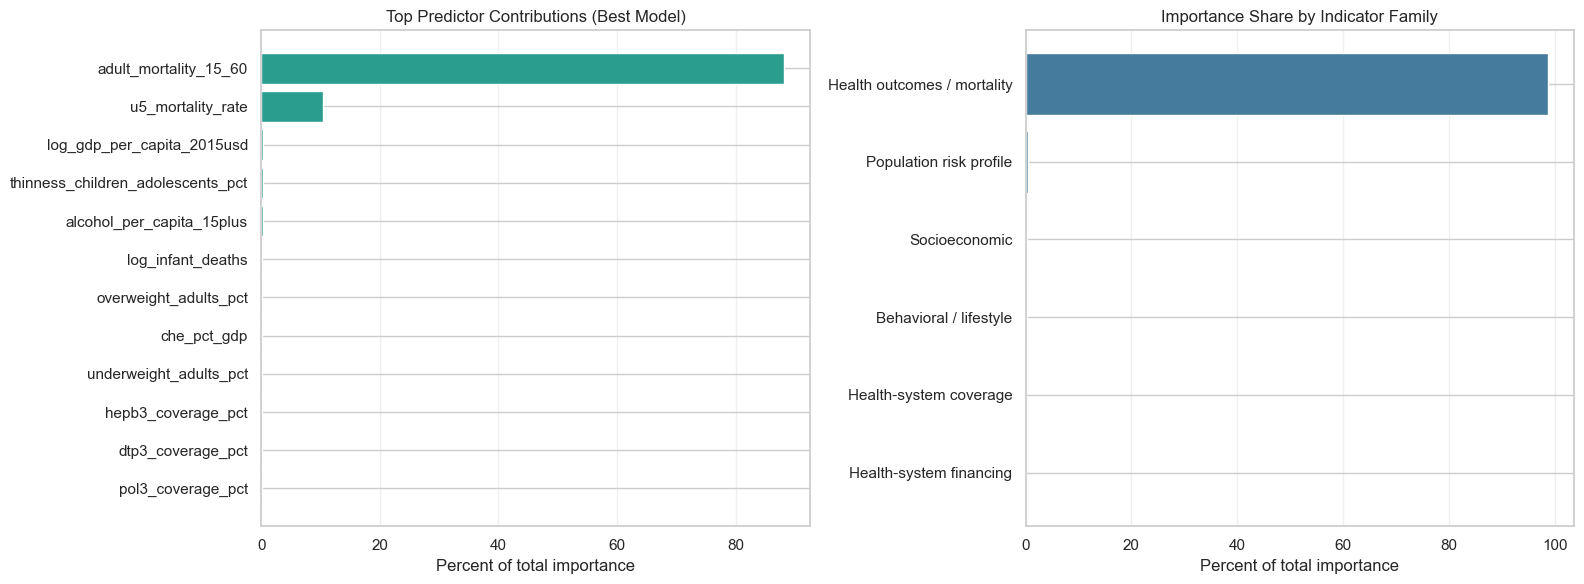

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/project_final_indicator_importance_summary.png


In [5]:
top_features = importance_df.head(12).copy()

indicator_group_map = {
    'adult_mortality_15_60': 'Health outcomes / mortality',
    'u5_mortality_rate': 'Health outcomes / mortality',
    'infant_deaths': 'Health outcomes / mortality',
    'log_infant_deaths': 'Health outcomes / mortality',
    'hepb3_coverage_pct': 'Health-system coverage',
    'pol3_coverage_pct': 'Health-system coverage',
    'dtp3_coverage_pct': 'Health-system coverage',
    'che_pct_gdp': 'Health-system financing',
    'gdp_per_capita_2015usd': 'Socioeconomic',
    'log_gdp_per_capita_2015usd': 'Socioeconomic',
    'alcohol_per_capita_15plus': 'Behavioral / lifestyle',
    'overweight_adults_pct': 'Population risk profile',
    'underweight_adults_pct': 'Population risk profile',
    'thinness_children_adolescents_pct': 'Population risk profile',
}

top_features['Indicator_Group'] = top_features['Feature'].map(indicator_group_map).fillna('Other')

group_share = top_features.groupby('Indicator_Group', as_index=False)['Percent_Of_Total'].sum().sort_values('Percent_Of_Total', ascending=False)

display(top_features[['Feature', 'Importance', 'Percent_Of_Total', 'Indicator_Group']])
display(group_share)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(top_features['Feature'][::-1], top_features['Percent_Of_Total'][::-1], color='#2a9d8f')
axes[0].set_title('Top Predictor Contributions (Best Model)')
axes[0].set_xlabel('Percent of total importance')
axes[0].grid(alpha=0.3, axis='x')

axes[1].barh(group_share['Indicator_Group'][::-1], group_share['Percent_Of_Total'][::-1], color='#457b9d')
axes[1].set_title('Importance Share by Indicator Family')
axes[1].set_xlabel('Percent of total importance')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
out_fig = IMG_DIR / 'project_final_indicator_importance_summary.png'
plt.savefig(out_fig, dpi=180)
plt.show()
print('Saved:', out_fig.resolve())


## 5) Comparison Across Modeling Strategies and Feature Representations

Representation summary:


,Feature_Set,mean_test_r2,best_test_r2,mean_test_rmse,best_test_rmse
1,log_enhanced,0.822162,0.988479,1.960685,0.754141
0,baseline,0.821331,0.988453,1.977324,0.754979
2,polynomial,0.825673,0.986593,1.884691,0.813526


Best representation per model family:


,Model,Feature_Set,Test_R2,Test_RMSE
0,Decision Tree (max_depth=10),baseline,0.977023,1.065014
1,DummyRegressor,baseline,-0.105004,7.385664
2,"Gradient Boosting (n_estimators=200, max_depth=3)",polynomial,0.984899,0.863406
3,Lasso (alpha=0.001),polynomial,0.980063,0.992054
4,Linear Regression,polynomial,0.980017,0.993201
5,"Random Forest (n_estimators=300, max_depth=15)",log_enhanced,0.988479,0.754141
6,Ridge (alpha=1.0),polynomial,0.980014,0.993269


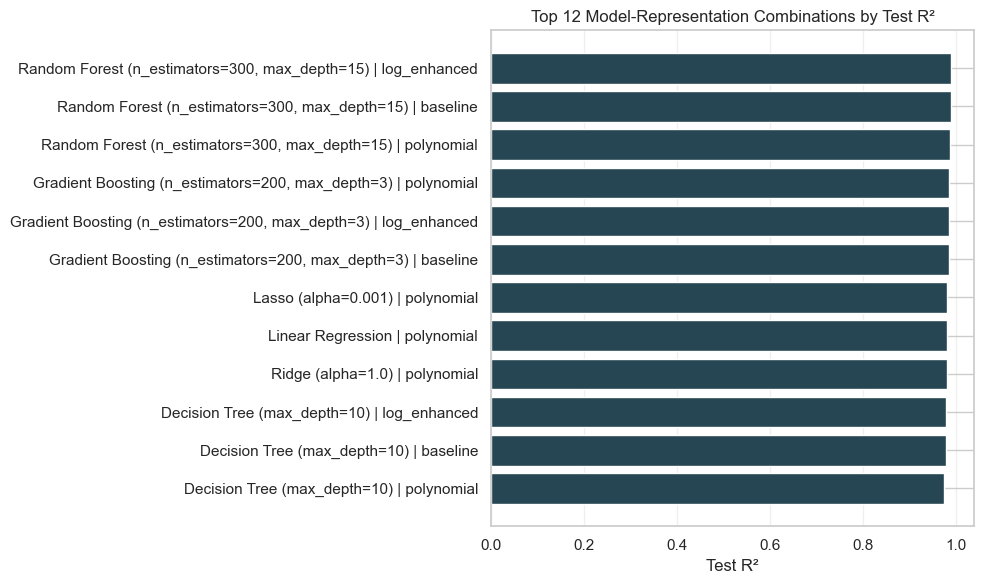

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/project_final_top_combinations.png


In [6]:
# performance by feature representation
rep_summary = comparison_df.groupby('Feature_Set', as_index=False).agg(
    mean_test_r2=('Test_R2', 'mean'),
    best_test_r2=('Test_R2', 'max'),
    mean_test_rmse=('Test_RMSE', 'mean'),
    best_test_rmse=('Test_RMSE', 'min'),
)

# best representation for each model class
best_rep_per_model = (
    comparison_df.sort_values(['Model', 'Test_R2'], ascending=[True, False])
    .groupby('Model', as_index=False)
    .first()[['Model', 'Feature_Set', 'Test_R2', 'Test_RMSE']]
)

print('Representation summary:')
display(rep_summary.sort_values('best_test_r2', ascending=False))
print('Best representation per model family:')
display(best_rep_per_model)

fig, ax = plt.subplots(figsize=(10, 6))
plot_df = comparison_df.copy()
plot_df['Model+Rep'] = plot_df['Model'] + ' | ' + plot_df['Feature_Set']
plot_df = plot_df.sort_values('Test_R2', ascending=False).head(12)
ax.barh(plot_df['Model+Rep'][::-1], plot_df['Test_R2'][::-1], color='#264653')
ax.set_title('Top 12 Model-Representation Combinations by Test R²')
ax.set_xlabel('Test R²')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
out_fig = IMG_DIR / 'project_final_top_combinations.png'
plt.savefig(out_fig, dpi=180)
plt.show()
print('Saved:', out_fig.resolve())


## 6) Robustness Snapshot for the Selected Best Combination

,Cutoff_Year,Test_R2,Test_RMSE
0,2014.0,0.988490,0.772651
1,2015.0,0.988577,0.763265
2,2016.0,0.988748,0.751518
3,2017.0,0.988449,0.755131


,Train_Fraction,Train_Samples,Test_R2,Test_RMSE
13,0.25,864.0,0.984219,0.882619
14,0.50,1728.0,0.986777,0.807939
15,0.75,2592.0,0.987173,0.795739
16,1.00,3456.0,0.988517,0.752897


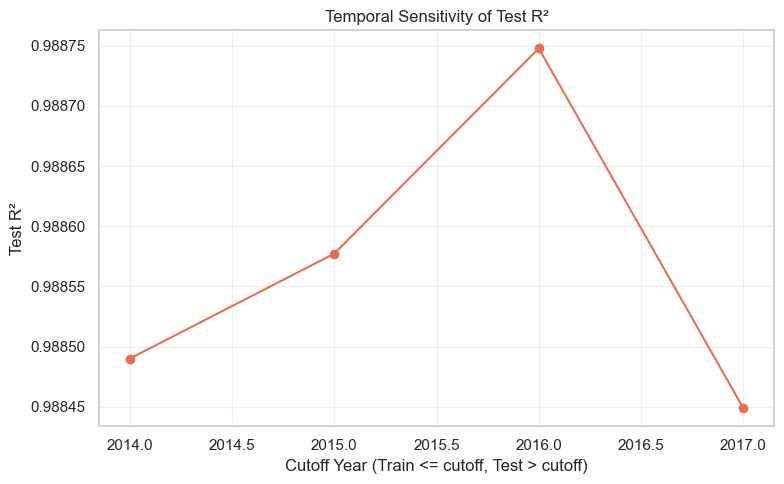

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/project_final_temporal_sensitivity.png


In [7]:
temporal_sens = robustness_df[robustness_df['Check'] == 'Temporal Sensitivity'].copy()
size_sens = robustness_df[robustness_df['Check'] == 'Sample Size Sensitivity'].copy()

display(temporal_sens[['Cutoff_Year', 'Test_R2', 'Test_RMSE']])
if not size_sens.empty:
    display(size_sens[['Train_Fraction', 'Train_Samples', 'Test_R2', 'Test_RMSE']])

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(temporal_sens['Cutoff_Year'], temporal_sens['Test_R2'], marker='o', color='#e76f51')
ax.set_title('Temporal Sensitivity of Test R²')
ax.set_xlabel('Cutoff Year (Train <= cutoff, Test > cutoff)')
ax.set_ylabel('Test R²')
ax.grid(alpha=0.3)
plt.tight_layout()
out_fig = IMG_DIR / 'project_final_temporal_sensitivity.png'
plt.savefig(out_fig, dpi=180)
plt.show()
print('Saved:', out_fig.resolve())


## 7) Final Answer to the Research Question

### Best Model and Best Feature Engineering Choice
- **Best model**: `Random Forest (n_estimators=300, max_depth=15)`
- **Best feature representation**: `log_enhanced`
- **Best combination**: `Random Forest + log_enhanced`

### Substantive Findings
- The strongest predictive signal is dominated by **mortality-related indicators**, especially:
  - `adult_mortality_15_60`
  - `u5_mortality_rate`
- Secondary contribution comes from socioeconomic and risk-profile indicators (for example logged GDP per capita and thinness-related measures).
- Across model families, tree-based ensembles (especially Random Forest) generalize best on the temporal holdout.
- Log-enhanced representation gives the most stable top performance relative to baseline and polynomial alternatives.

### Interpretation
- National life expectancy in this dataset is most tightly associated with population-level mortality burden and, secondarily, with socioeconomic conditions and health-system coverage proxies.
- More flexible non-linear models improve predictive performance, but gains are meaningful only when validated on future years.


## 8) Limitations and Scope

- This is a **predictive** analysis, not a causal identification design.
- National aggregates can hide within-country heterogeneity and subgroup disparities.
- The test horizon is limited to `2018-2021`; long-term structural shifts may alter performance.
- Indicator reporting quality may differ across country-years.
- The selected final combination is best **for this dataset and split protocol**, not necessarily universally optimal.


In [8]:
final_summary = pd.DataFrame([
    {
        'best_model': best_model_name,
        'best_feature_set': best_feature_set,
        'test_r2': final_metrics['Test_R2'],
        'test_rmse': final_metrics['Test_RMSE'],
        'test_mae': final_metrics['Test_MAE'],
        'n_train': len(train_df),
        'n_test': len(test_df),
        'train_year_min': int(train_df['Year'].min()),
        'train_year_max': int(train_df['Year'].max()),
        'test_year_min': int(test_df['Year'].min()),
        'test_year_max': int(test_df['Year'].max()),
    }
])

out_csv = DATA_DIR / 'project_final_summary.csv'
final_summary.to_csv(out_csv, index=False)
print('Saved:', out_csv.resolve())
display(final_summary)


Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/project_final_summary.csv


,best_model,best_feature_set,test_r2,test_rmse,test_mae,n_train,n_test,train_year_min,train_year_max,test_year_min,test_year_max
0,"Random Forest (n_estimators=300, max_depth=15)",log_enhanced,0.988479,0.754141,0.521731,3456,768,2000,2017,2018,2021
